# ResNet with TensorFlow
## An implementation of a Convolutional Neural Network using classes to classify the mnist handwritten digits database using the quickstart for experts guide on TensorFlow.

### Setup

In [1]:
# Import statements
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model, losses, models, layers, datasets, regularizers, optimizers
import matplotlib.pyplot as plt

TensorFlow version: 2.12.0


In [2]:
# Data
fashion_mnist = datasets.mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Scaling images between 0 and 1
x_train, x_test = x_train/255, x_test/255

# Resizing images to be 32x32 because that is the minimum
x_train = tf.pad(x_train, [[0,0], [2,2], [2,2]])
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)


# Create a validation set
x_val = x_train[-2000:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:]
y_train = y_train[:-2000]

# Batching and shuffling the dataset (Marked for review)
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

11490434/11490434 [==============================] - 1s 0us/step


### Building the Model

## First Pass

In [3]:
base_model = tf.keras.applications.ResNet152(weights="imagenet", include_top = False, input_shape = (32,32,3))

234698864/234698864 [==============================] - 7s 0us/step


In [4]:
# Base Model

for layer in base_model.layers:
    layer.trainable = False

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = Flatten()(base_model.output)
        self.d1 = Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(0.001))
        self.d2 = Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model = MyModel()
predictions = model


In [5]:
# Random Code
x = Flatten()(base_model.output)
x = Dense(1000, activation="relu")(x)
predictions = layers.Dense(10, activation = "softmax")(x)

In [6]:
head_model = Model(inputs = base_model.input, outputs=predictions)
head_model.compile(optimizer=optimizers.Adam(lr=0.0001), loss=losses.sparse_categorical_crossentropy, metrics=["accuracy"])

### Running the Model

In [7]:
initial_epochs = 40
history = head_model.fit(x_train, y_train, batch_size=64, epochs=initial_epochs, validation_data=(x_val, y_val))

Epoch 1/40
907/907 [==============================] - 50s 37ms/step - loss: 0.8936 - accuracy: 0.7052 - val_loss: 0.5129 - val_accuracy: 0.8465
Epoch 2/40
907/907 [==============================] - 28s 31ms/step - loss: 0.5847 - accuracy: 0.8094 - val_loss: 0.4135 - val_accuracy: 0.8775
Epoch 3/40
907/907 [==============================] - 29s 32ms/step - loss: 0.5102 - accuracy: 0.8340 - val_loss: 0.3758 - val_accuracy: 0.8850
Epoch 4/40
907/907 [==============================] - 29s 32ms/step - loss: 0.4513 - accuracy: 0.8520 - val_loss: 0.2937 - val_accuracy: 0.9200
Epoch 5/40
907/907 [==============================] - 28s 31ms/step - loss: 0.4140 - accuracy: 0.8630 - val_loss: 0.2840 - val_accuracy: 0.9145
Epoch 6/40
907/907 [==============================] - 29s 32ms/step - loss: 0.3899 - accuracy: 0.8722 - val_loss: 0.2503 - val_accuracy: 0.9345
Epoch 7/40
907/907 [==============================] - 29s 32ms/step - loss: 0.3680 - accuracy: 0.8792 - val_loss: 0.2353 - val_accuracy:

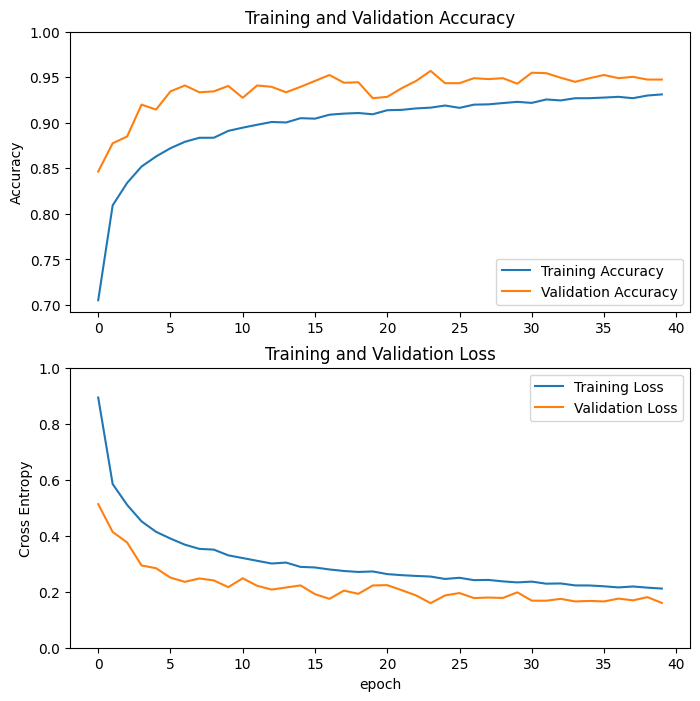

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [9]:
head_model.evaluate(x_test, y_test)

313/313 [==============================] - 9s 28ms/step - loss: 0.2124 - accuracy: 0.9302


[0.2124064713716507, 0.9301999807357788]

In [10]:
head_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [16]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 484

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
head_model.compile(optimizer="adam", loss=losses.sparse_categorical_crossentropy, metrics=["accuracy"])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = head_model.fit(x_train, y_train, initial_epoch=history.epoch[-1], batch_size=64, epochs=total_epochs, validation_data=(x_val, y_val), callbacks=[callback])

Number of layers in the base model:  515
Epoch 40/50


KeyboardInterrupt: ignored

In [19]:
head_model.evaluate(x_test, y_test)

313/313 [==============================] - 8s 26ms/step - loss: 0.2517 - accuracy: 0.9190


[0.2517106235027313, 0.9190000295639038]

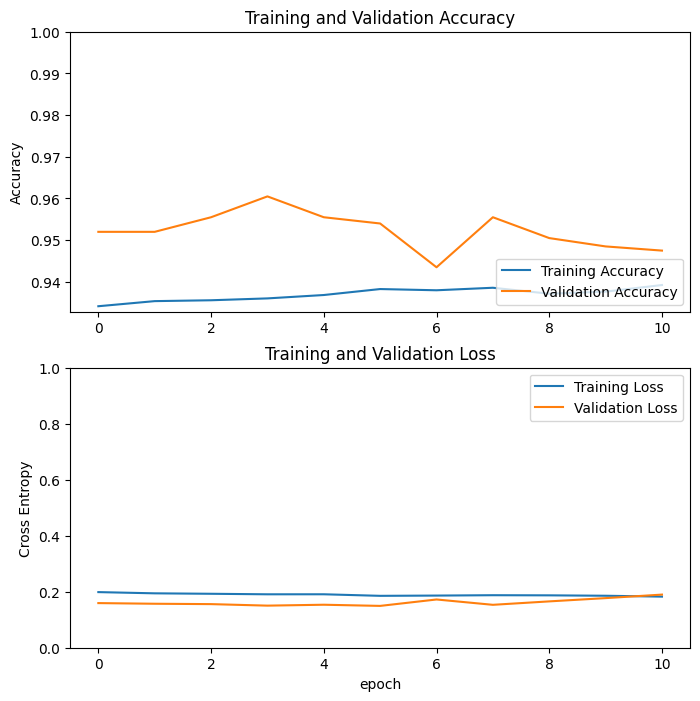

In [18]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()